# Train a Production Model

In this tutorial, you will use the existing hyperparameters that yielded the best performing model in the previous Tutorial 7 to train a production model on the full dataset, rather than just the training subset from a scaffold split. Deploying a model trained on the full dataset is one approach for a production model. Another approach, not demonstrated in this tutorial, could be combining the train and valid splits for training and evaluating with the test split. [K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) makes use of this approach. The production model could be shared with other researchers to predict on new data. When there is an updated version of the model input datasets, a model should be trained from scratch and *then* a new version of the production model should be generated. 

We will use these functions to retrain a best model for production and compare the production model with the best model. **Retrain doesn't replace the existing model; it creates a new model based on the same hyperparameters.** If there is an updated major AMPL version, the retrain method could also be used to update the model's AMPL version, not demonstrated in this tutorial. The `model_retrain` module provides a simple way to update models trained with a previous AMPL version.
- [create_prediction_pipeline_from_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.model_pipeline.create_prediction_pipeline_from_file)
- [train_model_from_tar](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model_from_tar)

We will use functions covered in Tutorial 5 to apply the models.

>**Comments**
>1. The first sentence doesn't make it clear what's going to be happening here. Try this:
>>"In this tutorial, you will use the hyperparameters that yielded the best performing model in the previous tutorial to train a "production" model on the full dataset, rather than just the
training subset from a scaffold split."
>2. I think we should avoid suggesting that deploying a model trained on the full dataset is best data science practice. It's more like, if that's what you prefer to do, AMPL provides an easy way to do it. Therefore, I would drop the second sentence and keep the third one, which says the same thing only a lot more clearly.
>3. Arguably, when the model input dataset is updated, the model should be retrained from scratch, and _then_ a production model should be generated.
>4. I don't understand how one would do what you suggest in the 4th sentence - how would you use the production models to assess performance over time?

## Import Packages

In [1]:
import pandas as pd
import os
from atomsci.ddm.utils import model_retrain as mr
from atomsci.ddm.utils import model_version_utils as mv
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-03-12 18:25:05.918685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 18:25:05.918756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 18:25:05.918801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 18:25:05.931360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 18:25:08.761216: W tensorflow/compiler/

## Start from saved best model

We're using the best performing model by valid $R^2$ score from Tutorial 7. This was a RF model. 

`dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz
Best valid r2 score:  0.5595899501867392
Model Parameters:  {"rf_estimators": 129, "rf_max_depth": 32, "rf_max_features": 95}`

Retraining a model trains based on the saved model_metadata. The model_metadata contains the model (hyper)parameters saved in the model target file. If the model_params `production` is `True`, *all* splitting related parameters will be ignored. `create_prediction_pipeline_from_file` will reload the saved model. The default model param sets `production` to `False`. The AMPL version is checked in case this is a saved model from a previous version of AMPL. The saved model AMPL version must match the installed major AMPL version in order to be used by `create_prediction_pipeline_from_file`.

>**Comments:**
1. "Setting the production parameter to True" _where_???
2. Have we talked about "model metadata" in any of the previous tutorials? I suspect not, so you have to clarify that this refers to the model (hyper)parameters saved in the model tarball file.
3. You need to say that *all* splitting related parameters are ignored, not just `previously_split`.
4. What do you mean by the "production split"?
5. Is it really true that the saved model AMPL version must match the installed version? Why? The whole idea of the `model_retrain` module, after all, is to provide a simple way to update models trained with a previous AMPL version.

In [2]:
#Tutorial 7 RF saved model_path
best_model_path='dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz'

#get installed AMPL version
print("installed AMPL version: " + str(mv.get_ampl_version()))

#get AMPL model version
print("best model AMPL version: " + str(mv.get_ampl_version_from_model(best_model_path)))

#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=best_model_path, model_type='best_model', featurization=None, verbose=False)

#show production is false
print("orig_params.production: " + str(best_model_pipe.orig_params.production))

INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"


installed AMPL version: 1.6.1
best model AMPL version: 1.6.0


num_model_tasks is deprecated and its value is ignored.
orig_params.production: False


## Retrain best model as production model

Setting the `production` argument for `train_model_from_tar` to `True` will set `production=True` in the model params. If the `production` argument for `train_model_from_tar` is `False`, the model will be retrained without changing any parameters. Note the production model's model parameter `production` is set to `True`.

In [3]:
odir='dataset/SLC6A3_models'

production_model = mr.train_model_from_tar(input=best_model_path, output=odir, production=True)

#check for parameters

num_model_tasks is deprecated and its value is ignored.


>**Comments:**
>1. Need to clarify: instead of "the retrain production setting", say "the `production` argument to `train_model_from_tar`".
>2. Need to fix the docstrings for model_retrain functions `train_model_from_tar` and `train_model_from_tracker`; both return a ModelPipeline object, but the doc says they return None.
>3. It might be misleading to refer to "retraining" a model. Should clarify somewhere that "retraining" doesn't replace the existing model; it creates a new model based on the same hyperparameters.

In [4]:
print("production_model.params.production: " + str(production_model.params.production))
print("production_model.params.model_tarball_path: " + str(production_model.params.model_tarball_path))

print("production model AMPL version: " + str(mv.get_ampl_version_from_model(production_model.params.model_tarball_path)))

INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_31d12602-b87b-4b19-b921-a0c405e54f30.tar.gz, 1.6.1


production_model.params.production: True
production_model.params.model_tarball_path: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_31d12602-b87b-4b19-b921-a0c405e54f30.tar.gz
production model AMPL version: 1.6.1


## Setup separate external test dataset

This is following Tutorial 5's steps for applying the models. This will compare the original best model and the production model, using a separate dataset that is structurally distant from everything in the production dataset. Note that since the production model is trained on all data, including the test subset, the original test subset **shouldn't** be used to evaluate the performance.

>**Comments:**
>Yes, it would be *much* better to evaluate the production model on a separate dataset, ideally one whose compounds are structurally distant from everything in the production dataset. I created such a dataset from GoStar data; we should try it out and compare performance on that dataset between the original best model and the production model.

In [5]:
#test_file_path = 'dataset/SLC6A3_Ki_ext_test_data.csv'
test_file_path = 'dataset/scaled_descriptors/SLC6A3_Ki_ext_test_data_with_rdkit_raw_descriptors.csv'
test_data = pd.read_csv(test_file_path)

test_data.head()

,compound_id,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,compound_346,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,8.970106,-4.751902,8.970106,0.825260,0.861181,315.264,293.088,...,0,0,0,0,0,0,0,0,0,0
1,compound_225,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,8.993202,-4.010824,8.993202,0.226986,0.739733,277.371,258.219,...,0,0,0,0,0,0,0,0,0,0
2,compound_166,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,13.525088,-5.060732,13.525088,1.095764,0.412331,455.598,422.334,...,0,0,0,0,0,0,0,0,0,0
3,compound_310,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,9.204719,-4.140132,9.204719,0.018450,0.581059,354.457,332.281,...,0,0,0,0,0,0,0,0,0,0
4,compound_284,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,17.710445,-4.117619,17.710445,0.229708,0.636234,297.398,281.270,...,0,0,0,0,0,0,0,1,0,0


## Apply best model

In [6]:
model_dir = best_model_path
input_df = test_data
id_col = 'compound_id'
smiles_col = 'base_rdkit_smiles'
response_col = 'avg_pKi'

print(model_dir)

best_pred_df = pfm.predict_from_model_file(model_path = model_dir, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      #external_training_data=test_file_path,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
best_pred_df.head()

dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz
Standardizing SMILES strings for 533 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.


,compound_id,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,compound_346,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,8.970106,-4.751902,8.970106,0.825260,0.861181,315.264,293.088,...,0,0,0,0,0,0,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,7.284956,0.955853
1,compound_225,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,8.993202,-4.010824,8.993202,0.226986,0.739733,277.371,258.219,...,0,0,0,0,0,0,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,7.143886,0.801133
2,compound_166,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,13.525088,-5.060732,13.525088,1.095764,0.412331,455.598,422.334,...,0,0,0,0,0,0,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,7.676473,0.947577
3,compound_310,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,9.204719,-4.140132,9.204719,0.018450,0.581059,354.457,332.281,...,0,0,0,0,0,0,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,6.379872,1.014355
4,compound_284,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,17.710445,-4.117619,17.710445,0.229708,0.636234,297.398,281.270,...,0,0,0,1,0,0,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,6.949374,0.964244


In [7]:
actual_value = best_pred_df['avg_pKi_actual']
predicted_value = best_pred_df['avg_pKi_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)
print("Best model r2_score: " + str(r2))

Best model r2_score: 0.156877


## Apply production model and plot performances

This is a demonstration of using the production model to predict. This is an evaluation of the production model performance.

In [8]:
model_dir = production_model.params.model_tarball_path

# View the pred_df dataframe
prod_pred_df = pfm.predict_from_model_file(model_path = model_dir, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      #external_training_data=split_file_dir,
                                      is_featurized=False)
                                      
prod_pred_df.head()

Standardizing SMILES strings for 533 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_31d12602-b87b-4b19-b921-a0c405e54f30.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_31d12602-b87b-4b19-b921-a0c405e54f30.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.


,compound_id,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,compound_346,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,8.970106,-4.751902,8.970106,0.825260,0.861181,315.264,293.088,...,0,0,0,0,0,0,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,7.336011,0.857905
1,compound_225,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,8.993202,-4.010824,8.993202,0.226986,0.739733,277.371,258.219,...,0,0,0,0,0,0,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,6.690491,0.983557
2,compound_166,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,13.525088,-5.060732,13.525088,1.095764,0.412331,455.598,422.334,...,0,0,0,0,0,0,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,6.971507,0.722885
3,compound_310,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,9.204719,-4.140132,9.204719,0.018450,0.581059,354.457,332.281,...,0,0,0,0,0,0,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,6.187998,1.161740
4,compound_284,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,17.710445,-4.117619,17.710445,0.229708,0.636234,297.398,281.270,...,0,0,0,1,0,0,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,6.644015,1.209780


In [9]:
actual_value = prod_pred_df['avg_pKi_actual']
predicted_value = prod_pred_df['avg_pKi_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)
print("Production model r2_score: " + str(r2))

Production model r2_score: 0.271743


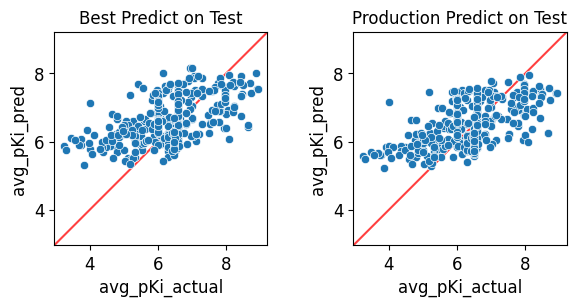

In [10]:
#show plots in same figure
fig, ax = plt.subplots(1,2)
pp.plot_pred_vs_actual_from_df(best_pred_df, actual_col='avg_pKi_actual', pred_col='avg_pKi_pred', label='Best Predict on Test', ax=ax[0])  # plot1
pp.plot_pred_vs_actual_from_df(prod_pred_df, actual_col='avg_pKi_actual', pred_col='avg_pKi_pred', label='Production Predict on Test', ax=ax[1])  # plot2
fig.tight_layout(pad=3.0)
fig.show()

>**Comments:**
>1. It would be better to show both plots (for the original best model and the production model) together in the same figure.
>2. Of course, the plot looks better with the production model precisely because the "test set" is now included in the training data. If we switch to using an external test set, that won't be the case and we'll get to see how the production model performs differently (hopefully better).

The production model with r2_score: 0.258543 does perform *better* than the best model with r2_score: 0.156877, but neither are great r2 scores. The production plot has a slight increase in points concentrated along the diagonal. A possible explanation is that since the external dataset compounds were filtered so none have Tanimoto distance < 0.4 to any compound in the original model dataset, this test set is too dissimiliar to fit either model. It could be interesting to evaluate whether the models' performance improves with closer Tanimoto distance thresholds.

In [11]:
# Production model path
production_model.params.model_tarball_path

'dataset/SLC6A3_models/SLC6A3_Ki_curated_model_31d12602-b87b-4b19-b921-a0c405e54f30.tar.gz'

## Other functions with Production parameter
`Production` is an available boolean parameter in these other AMPL functions. If `production` is set to True, the model will be trained in production mode. This uses the entire dataset in training, validation, and test. If using epochs, it will train exactly max_epochs and save the last one.
- [train_model](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model)
- [train_models_from_dataset_keys](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_models_from_dataset_keys)

>**Comments**:
1. EpochManager and EpochManagerKFold are not part of the public API, so should not be listed here.
2. I think we have a convention of putting parameter names in backquotes, so the production parameter would be rendered as `production`.
3. Maybe this section should come toward the end of the tutorial, given that we dont use any of these functions here.

Future queries for this dataset will use this production model for prediction. In the next Tutorial 9, you'll explore visualization methods for presenting the predicted result for a model.